In [1]:
import numpy as np
import torch
import transformers
import matplotlib.pyplot as plt

from transformers import BertConfig
from transformers import get_cosine_schedule_with_warmup
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
from tqdm.auto import tqdm

from models import BertForDiffusion, DiffusionLM
from data_utils import load_e2enlg_dataset_and_tokenizer, E2enlgDataset, load_rocstories_dataset_and_tokenizer, RocstoriesDataset
from noise_schedule import get_named_beta_schedule
from train_utils import train, evaluate

%matplotlib inline

In [2]:
# dataset args
max_len = 72    # maximum length of input_ids
vocab_threshold = 10    # occurrence time < threshold token as [UNK]
test_size = 0.1     # size of evaluation dataset

# training args
batch_size = 32
device = torch.device("cuda:0")
lr = 2e-4
num_epoch = 50
weight_decay = 0
num_warmup_steps = 100

# model args
word_embedding_dim = 128
hidden_size = 512
num_hidden_layers = 4
num_attention_heads = 8
intermediate_size = 2048
max_position_embeddings = max_len

In [3]:
tokenized_rocstories_dataset, tokenizer = load_rocstories_dataset_and_tokenizer(max_len=max_len, vocab_threshold=vocab_threshold)

rev_tokenizer = {v: k for k, v in tokenizer.items()}

train_set, eval_set = train_test_split(tokenized_rocstories_dataset, test_size=test_size, shuffle=True)

train_dataset = RocstoriesDataset(data_lst=train_set['input_ids'], attention_mask_lst=train_set['attention_mask'])
print("Training set size:",len(train_dataset))
eval_dataset = RocstoriesDataset(data_lst=eval_set['input_ids'], attention_mask_lst=eval_set['attention_mask'])
print("Evaluation set size:", len(eval_dataset))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)

No config specified, defaulting to: roc_stories/all
Reusing dataset roc_stories (/home/dingyizhou/.cache/huggingface/datasets/wza___roc_stories/all/2.1.0/43e2851d9f31e08e4b2dd07a8057ed7a64cbb25cc7105d09856c14e638695506)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/98161 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?ba/s]

Training set size: 88344
Evaluation set size: 9817


In [4]:
config = BertConfig(vocab_size=len(tokenizer), hidden_size=hidden_size, num_hidden_layers=num_hidden_layers, num_attention_heads=num_attention_heads, intermediate_size=intermediate_size, max_position_embeddings=max_position_embeddings, pad_token_id=tokenizer['[PAD]'])

config.T = 2000
config.word_embedding_dim = word_embedding_dim

print(config)

BertConfig {
  "T": 2000,
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 2048,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 72,
  "model_type": "bert",
  "num_attention_heads": 8,
  "num_hidden_layers": 4,
  "pad_token_id": 3,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 11831,
  "word_embedding_dim": 128
}



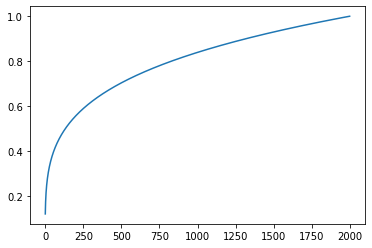

In [5]:
betas = torch.Tensor(get_named_beta_schedule(schedule_name="sqrt", num_diffusion_timesteps=config.T))
# betas = torch.Tensor(get_named_beta_schedule(schedule_name="linear", num_diffusion_timesteps=config.T))

alphas = 1. - betas
alphas_bar = torch.cumprod(alphas, dim=0)
sqrt_one_minus_alphas_bar = torch.sqrt(1. - alphas_bar)
plt.plot(sqrt_one_minus_alphas_bar)

In [6]:
diffusion_model = DiffusionLM(config=config, betas=betas, use_shared_weight=True, add_emb_noise=False).to(device)

print("Diffusion model #parameters:")
print(sum([p.numel() for p in diffusion_model.parameters()]))

optimizer = torch.optim.AdamW(diffusion_model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = get_cosine_schedule_with_warmup(optimizer=optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_epoch*len(train_dataloader))

Diffusion model #parameters:
15854647


In [8]:
loss_terms_dict_lst = []
loss_terms_weights = {'mse':1, 'L_T':1, 'rounding': 1}
progress_bar = tqdm(range(num_epoch*len(train_dataloader)))

for epoch in range(num_epoch):
    print("epoch:",epoch+1)
    loss_terms_dict_lst.append(train(diffusion_model=diffusion_model, dataloader=train_dataloader, optimizer=optimizer, scheduler=scheduler ,progress_bar=progress_bar, loss_terms_weights=loss_terms_weights ,verbose=True))
    evaluate(diffusion_model=diffusion_model, dataloader=eval_dataloader, loss_terms_weights=loss_terms_weights)

  0%|          | 0/59150 [00:00<?, ?it/s]

epoch: 1
step: 100
mse  training loss=0.4567
L_T  training loss=0.0000
rounding  training loss=0.5953
step: 200
mse  training loss=0.2924
L_T  training loss=0.0000
rounding  training loss=0.4180
step: 300
mse  training loss=0.2502
L_T  training loss=0.0000
rounding  training loss=0.2713
step: 400
mse  training loss=0.2253
L_T  training loss=0.0000
rounding  training loss=0.1817
step: 500
mse  training loss=0.2080
L_T  training loss=0.0000
rounding  training loss=0.1274
step: 600
mse  training loss=0.2042
L_T  training loss=0.0000
rounding  training loss=0.0931
step: 700
mse  training loss=0.1963
L_T  training loss=0.0000
rounding  training loss=0.0706
step: 800
mse  training loss=0.1919
L_T  training loss=0.0000
rounding  training loss=0.0550
step: 900
mse  training loss=0.1834
L_T  training loss=0.0000
rounding  training loss=0.0440
step: 1000
mse  training loss=0.1792
L_T  training loss=0.0000
rounding  training loss=0.0360
step: 1100
mse  training loss=0.1775
L_T  training loss=0.00

  0%|          | 0/132 [00:00<?, ?it/s]

eval loss=0.1908
epoch: 2
step: 100
mse  training loss=0.1721
L_T  training loss=0.0000
rounding  training loss=0.0225
step: 200
mse  training loss=0.1651
L_T  training loss=0.0000
rounding  training loss=0.0197
step: 300
mse  training loss=0.1655
L_T  training loss=0.0000
rounding  training loss=0.0172
step: 400
mse  training loss=0.1631
L_T  training loss=0.0000
rounding  training loss=0.0153
step: 500
mse  training loss=0.1620
L_T  training loss=0.0000
rounding  training loss=0.0137
step: 600
mse  training loss=0.1585
L_T  training loss=0.0000
rounding  training loss=0.0125
step: 700
mse  training loss=0.1565
L_T  training loss=0.0000
rounding  training loss=0.0114
step: 800
mse  training loss=0.1469
L_T  training loss=0.0000
rounding  training loss=0.0104
step: 900
mse  training loss=0.1472
L_T  training loss=0.0000
rounding  training loss=0.0096
step: 1000
mse  training loss=0.1486
L_T  training loss=0.0000
rounding  training loss=0.0089
step: 1100
mse  training loss=0.1458
L_T  t

  0%|          | 0/132 [00:00<?, ?it/s]

eval loss=0.1443
epoch: 3
step: 100
mse  training loss=0.1400
L_T  training loss=0.0000
rounding  training loss=0.0075
step: 200
mse  training loss=0.1383
L_T  training loss=0.0000
rounding  training loss=0.0071
step: 300
mse  training loss=0.1403
L_T  training loss=0.0000
rounding  training loss=0.0068
step: 400
mse  training loss=0.1370
L_T  training loss=0.0000
rounding  training loss=0.0065
step: 500
mse  training loss=0.1347
L_T  training loss=0.0000
rounding  training loss=0.0062
step: 600
mse  training loss=0.1309
L_T  training loss=0.0000
rounding  training loss=0.0060
step: 700
mse  training loss=0.1301
L_T  training loss=0.0000
rounding  training loss=0.0058
step: 800
mse  training loss=0.1317
L_T  training loss=0.0000
rounding  training loss=0.0057
step: 900
mse  training loss=0.1285
L_T  training loss=0.0000
rounding  training loss=0.0055
step: 1000
mse  training loss=0.1268
L_T  training loss=0.0000
rounding  training loss=0.0054
step: 1100
mse  training loss=0.1298
L_T  t

  0%|          | 0/132 [00:00<?, ?it/s]

eval loss=0.1266
epoch: 4
step: 100
mse  training loss=0.1243
L_T  training loss=0.0000
rounding  training loss=0.0051
step: 200
mse  training loss=0.1226
L_T  training loss=0.0000
rounding  training loss=0.0051
step: 300
mse  training loss=0.1235
L_T  training loss=0.0000
rounding  training loss=0.0050
step: 400
mse  training loss=0.1226
L_T  training loss=0.0000
rounding  training loss=0.0051
step: 500
mse  training loss=0.1197
L_T  training loss=0.0000
rounding  training loss=0.0049
step: 600
mse  training loss=0.1167
L_T  training loss=0.0000
rounding  training loss=0.0049
step: 700
mse  training loss=0.1191
L_T  training loss=0.0000
rounding  training loss=0.0049
step: 800
mse  training loss=0.1175
L_T  training loss=0.0000
rounding  training loss=0.0049
step: 900
mse  training loss=0.1140
L_T  training loss=0.0000
rounding  training loss=0.0049
step: 1000
mse  training loss=0.1151
L_T  training loss=0.0000
rounding  training loss=0.0048
step: 1100
mse  training loss=0.1125
L_T  t

  0%|          | 0/132 [00:00<?, ?it/s]

eval loss=0.1149
epoch: 5
step: 100
mse  training loss=0.1136
L_T  training loss=0.0000
rounding  training loss=0.0049
step: 200
mse  training loss=0.1112
L_T  training loss=0.0000
rounding  training loss=0.0049
step: 300
mse  training loss=0.1136
L_T  training loss=0.0000
rounding  training loss=0.0049
step: 400
mse  training loss=0.1105
L_T  training loss=0.0000
rounding  training loss=0.0049
step: 500
mse  training loss=0.1116
L_T  training loss=0.0000
rounding  training loss=0.0050
step: 600
mse  training loss=0.1075
L_T  training loss=0.0000
rounding  training loss=0.0049
step: 700
mse  training loss=0.1088
L_T  training loss=0.0000
rounding  training loss=0.0049
step: 800
mse  training loss=0.1070
L_T  training loss=0.0000
rounding  training loss=0.0049
step: 900
mse  training loss=0.1071
L_T  training loss=0.0000
rounding  training loss=0.0049
step: 1000
mse  training loss=0.1105
L_T  training loss=0.0000
rounding  training loss=0.0050
step: 1100
mse  training loss=0.1066
L_T  t

  0%|          | 0/132 [00:00<?, ?it/s]

eval loss=0.1067
epoch: 6
step: 100
mse  training loss=0.1046
L_T  training loss=0.0000
rounding  training loss=0.0049
step: 200
mse  training loss=0.1029
L_T  training loss=0.0000
rounding  training loss=0.0050
step: 300
mse  training loss=0.1041
L_T  training loss=0.0000
rounding  training loss=0.0050
step: 400
mse  training loss=0.1028
L_T  training loss=0.0000
rounding  training loss=0.0050
step: 500
mse  training loss=0.1028
L_T  training loss=0.0000
rounding  training loss=0.0050
step: 600
mse  training loss=0.1032
L_T  training loss=0.0000
rounding  training loss=0.0050
step: 700
mse  training loss=0.1010
L_T  training loss=0.0000
rounding  training loss=0.0051
step: 800
mse  training loss=0.1020
L_T  training loss=0.0000
rounding  training loss=0.0051
step: 900
mse  training loss=0.0998
L_T  training loss=0.0000
rounding  training loss=0.0051
step: 1000
mse  training loss=0.0978
L_T  training loss=0.0000
rounding  training loss=0.0051
step: 1100
mse  training loss=0.1010
L_T  t

  0%|          | 0/132 [00:00<?, ?it/s]

eval loss=0.1025
epoch: 7
step: 100
mse  training loss=0.0973
L_T  training loss=0.0000
rounding  training loss=0.0050
step: 200
mse  training loss=0.0986
L_T  training loss=0.0000
rounding  training loss=0.0050
step: 300
mse  training loss=0.0964
L_T  training loss=0.0000
rounding  training loss=0.0050
step: 400
mse  training loss=0.0983
L_T  training loss=0.0000
rounding  training loss=0.0051
step: 500
mse  training loss=0.0955
L_T  training loss=0.0000
rounding  training loss=0.0050
step: 600
mse  training loss=0.0967
L_T  training loss=0.0000
rounding  training loss=0.0050
step: 700
mse  training loss=0.0978
L_T  training loss=0.0000
rounding  training loss=0.0051
step: 800
mse  training loss=0.0963
L_T  training loss=0.0000
rounding  training loss=0.0051
step: 900
mse  training loss=0.0967
L_T  training loss=0.0000
rounding  training loss=0.0050
step: 1000
mse  training loss=0.0960
L_T  training loss=0.0000
rounding  training loss=0.0051
step: 1100
mse  training loss=0.0937
L_T  t

  0%|          | 0/132 [00:00<?, ?it/s]

eval loss=0.0978
epoch: 8
step: 100
mse  training loss=0.0951
L_T  training loss=0.0000
rounding  training loss=0.0051
step: 200
mse  training loss=0.0955
L_T  training loss=0.0000
rounding  training loss=0.0052
step: 300
mse  training loss=0.0942
L_T  training loss=0.0000
rounding  training loss=0.0051
step: 400
mse  training loss=0.0928
L_T  training loss=0.0000
rounding  training loss=0.0052
step: 500
mse  training loss=0.0913
L_T  training loss=0.0000
rounding  training loss=0.0051
step: 600
mse  training loss=0.0955
L_T  training loss=0.0000
rounding  training loss=0.0052
step: 700
mse  training loss=0.0959
L_T  training loss=0.0000
rounding  training loss=0.0052
step: 800
mse  training loss=0.0925
L_T  training loss=0.0000
rounding  training loss=0.0051
step: 900
mse  training loss=0.0912
L_T  training loss=0.0000
rounding  training loss=0.0051
step: 1000
mse  training loss=0.0917
L_T  training loss=0.0000
rounding  training loss=0.0051
step: 1100
mse  training loss=0.0926
L_T  t

  0%|          | 0/132 [00:00<?, ?it/s]

eval loss=0.0932
epoch: 9
step: 100
mse  training loss=0.0913
L_T  training loss=0.0000
rounding  training loss=0.0050
step: 200
mse  training loss=0.0907
L_T  training loss=0.0000
rounding  training loss=0.0051
step: 300
mse  training loss=0.0914
L_T  training loss=0.0000
rounding  training loss=0.0051
step: 400
mse  training loss=0.0910
L_T  training loss=0.0000
rounding  training loss=0.0051
step: 500
mse  training loss=0.0891
L_T  training loss=0.0000
rounding  training loss=0.0051
step: 600
mse  training loss=0.0887
L_T  training loss=0.0000
rounding  training loss=0.0050
step: 700
mse  training loss=0.0889
L_T  training loss=0.0000
rounding  training loss=0.0050
step: 800
mse  training loss=0.0887
L_T  training loss=0.0000
rounding  training loss=0.0049
step: 900
mse  training loss=0.0909
L_T  training loss=0.0000
rounding  training loss=0.0051
step: 1000
mse  training loss=0.0901
L_T  training loss=0.0000
rounding  training loss=0.0050
step: 1100
mse  training loss=0.0881
L_T  t

  0%|          | 0/132 [00:00<?, ?it/s]

eval loss=0.0915
epoch: 10
step: 100
mse  training loss=0.0895
L_T  training loss=0.0000
rounding  training loss=0.0050
step: 200
mse  training loss=0.0900
L_T  training loss=0.0000
rounding  training loss=0.0051
step: 300
mse  training loss=0.0876
L_T  training loss=0.0000
rounding  training loss=0.0050
step: 400
mse  training loss=0.0876
L_T  training loss=0.0000
rounding  training loss=0.0050
step: 500
mse  training loss=0.0889
L_T  training loss=0.0000
rounding  training loss=0.0050
step: 600
mse  training loss=0.0878
L_T  training loss=0.0000
rounding  training loss=0.0050
step: 700
mse  training loss=0.0870
L_T  training loss=0.0000
rounding  training loss=0.0050
step: 800
mse  training loss=0.0899
L_T  training loss=0.0000
rounding  training loss=0.0050
step: 900
mse  training loss=0.0883
L_T  training loss=0.0000
rounding  training loss=0.0051
step: 1000
mse  training loss=0.0894
L_T  training loss=0.0000
rounding  training loss=0.0050
step: 1100
mse  training loss=0.0876
L_T  

  0%|          | 0/132 [00:00<?, ?it/s]

eval loss=0.0893
epoch: 11
step: 100
mse  training loss=0.0869
L_T  training loss=0.0000
rounding  training loss=0.0051
step: 200
mse  training loss=0.0890
L_T  training loss=0.0000
rounding  training loss=0.0051
step: 300
mse  training loss=0.0877
L_T  training loss=0.0000
rounding  training loss=0.0052
step: 400
mse  training loss=0.0863
L_T  training loss=0.0000
rounding  training loss=0.0051
step: 500
mse  training loss=0.0860
L_T  training loss=0.0000
rounding  training loss=0.0051
step: 600
mse  training loss=0.0870
L_T  training loss=0.0000
rounding  training loss=0.0051
step: 700
mse  training loss=0.0871
L_T  training loss=0.0000
rounding  training loss=0.0051
step: 800
mse  training loss=0.0856
L_T  training loss=0.0000
rounding  training loss=0.0051
step: 900
mse  training loss=0.0855
L_T  training loss=0.0000
rounding  training loss=0.0049
step: 1000
mse  training loss=0.0864
L_T  training loss=0.0000
rounding  training loss=0.0051
step: 1100
mse  training loss=0.0838
L_T  

  0%|          | 0/132 [00:00<?, ?it/s]

eval loss=0.0841
epoch: 12
step: 100
mse  training loss=0.0814
L_T  training loss=0.0000
rounding  training loss=0.0049
step: 200
mse  training loss=0.0861
L_T  training loss=0.0000
rounding  training loss=0.0049
step: 300
mse  training loss=0.0849
L_T  training loss=0.0000
rounding  training loss=0.0049
step: 400
mse  training loss=0.0842
L_T  training loss=0.0000
rounding  training loss=0.0049
step: 500
mse  training loss=0.0842
L_T  training loss=0.0000
rounding  training loss=0.0049
step: 600
mse  training loss=0.0854
L_T  training loss=0.0000
rounding  training loss=0.0049
step: 700
mse  training loss=0.0859
L_T  training loss=0.0000
rounding  training loss=0.0050
step: 800
mse  training loss=0.0855
L_T  training loss=0.0000
rounding  training loss=0.0051
step: 900
mse  training loss=0.0851
L_T  training loss=0.0000
rounding  training loss=0.0050
step: 1000
mse  training loss=0.0862
L_T  training loss=0.0000
rounding  training loss=0.0050
step: 1100
mse  training loss=0.0863
L_T  

  0%|          | 0/132 [00:00<?, ?it/s]

eval loss=0.0841
epoch: 13
step: 100
mse  training loss=0.0839
L_T  training loss=0.0000
rounding  training loss=0.0050
step: 200
mse  training loss=0.0845
L_T  training loss=0.0000
rounding  training loss=0.0050
step: 300
mse  training loss=0.0813
L_T  training loss=0.0000
rounding  training loss=0.0049
step: 400
mse  training loss=0.0818
L_T  training loss=0.0000
rounding  training loss=0.0049
step: 500
mse  training loss=0.0838
L_T  training loss=0.0000
rounding  training loss=0.0048
step: 600
mse  training loss=0.0804
L_T  training loss=0.0000
rounding  training loss=0.0049
step: 700
mse  training loss=0.0854
L_T  training loss=0.0000
rounding  training loss=0.0048
step: 800
mse  training loss=0.0801
L_T  training loss=0.0000
rounding  training loss=0.0048
step: 900
mse  training loss=0.0814
L_T  training loss=0.0000
rounding  training loss=0.0048
step: 1000
mse  training loss=0.0821
L_T  training loss=0.0000
rounding  training loss=0.0047
step: 1100
mse  training loss=0.0819
L_T  

  0%|          | 0/132 [00:00<?, ?it/s]

eval loss=0.0871
epoch: 14
step: 100
mse  training loss=0.0822
L_T  training loss=0.0000
rounding  training loss=0.0047
step: 200
mse  training loss=0.0823
L_T  training loss=0.0000
rounding  training loss=0.0048
step: 300
mse  training loss=0.0816
L_T  training loss=0.0000
rounding  training loss=0.0048
step: 400
mse  training loss=0.0814
L_T  training loss=0.0000
rounding  training loss=0.0048
step: 500
mse  training loss=0.0810
L_T  training loss=0.0000
rounding  training loss=0.0047
step: 600
mse  training loss=0.0824
L_T  training loss=0.0000
rounding  training loss=0.0047
step: 700
mse  training loss=0.0811
L_T  training loss=0.0000
rounding  training loss=0.0047
step: 800
mse  training loss=0.0830
L_T  training loss=0.0000
rounding  training loss=0.0048
step: 900
mse  training loss=0.0820
L_T  training loss=0.0000
rounding  training loss=0.0047
step: 1000
mse  training loss=0.0826
L_T  training loss=0.0000
rounding  training loss=0.0048
step: 1100
mse  training loss=0.0825
L_T  

  0%|          | 0/132 [00:00<?, ?it/s]

eval loss=0.0837
epoch: 15
step: 100
mse  training loss=0.0813
L_T  training loss=0.0000
rounding  training loss=0.0048
step: 200
mse  training loss=0.0836
L_T  training loss=0.0000
rounding  training loss=0.0048
step: 300
mse  training loss=0.0813
L_T  training loss=0.0000
rounding  training loss=0.0047
step: 400
mse  training loss=0.0827
L_T  training loss=0.0000
rounding  training loss=0.0047
step: 500
mse  training loss=0.0800
L_T  training loss=0.0000
rounding  training loss=0.0047
step: 600
mse  training loss=0.0798
L_T  training loss=0.0000
rounding  training loss=0.0047
step: 700
mse  training loss=0.0825
L_T  training loss=0.0000
rounding  training loss=0.0047
step: 800
mse  training loss=0.0821
L_T  training loss=0.0000
rounding  training loss=0.0047
step: 900
mse  training loss=0.0798
L_T  training loss=0.0000
rounding  training loss=0.0047
step: 1000
mse  training loss=0.0800
L_T  training loss=0.0000
rounding  training loss=0.0047
step: 1100
mse  training loss=0.0791
L_T  

  0%|          | 0/132 [00:00<?, ?it/s]

eval loss=0.0811
epoch: 16
step: 100
mse  training loss=0.0788
L_T  training loss=0.0000
rounding  training loss=0.0046
step: 200
mse  training loss=0.0787
L_T  training loss=0.0000
rounding  training loss=0.0046
step: 300
mse  training loss=0.0814
L_T  training loss=0.0000
rounding  training loss=0.0046
step: 400
mse  training loss=0.0817
L_T  training loss=0.0000
rounding  training loss=0.0046
step: 500
mse  training loss=0.0819
L_T  training loss=0.0000
rounding  training loss=0.0047
step: 600
mse  training loss=0.0795
L_T  training loss=0.0000
rounding  training loss=0.0046
step: 700
mse  training loss=0.0823
L_T  training loss=0.0000
rounding  training loss=0.0047
step: 800
mse  training loss=0.0811
L_T  training loss=0.0000
rounding  training loss=0.0047
step: 900
mse  training loss=0.0793
L_T  training loss=0.0000
rounding  training loss=0.0047
step: 1000
mse  training loss=0.0810
L_T  training loss=0.0000
rounding  training loss=0.0047
step: 1100
mse  training loss=0.0777
L_T  

  0%|          | 0/132 [00:00<?, ?it/s]

eval loss=0.0799
epoch: 17
step: 100
mse  training loss=0.0799
L_T  training loss=0.0000
rounding  training loss=0.0046
step: 200
mse  training loss=0.0794
L_T  training loss=0.0000
rounding  training loss=0.0046
step: 300
mse  training loss=0.0801
L_T  training loss=0.0000
rounding  training loss=0.0046
step: 400
mse  training loss=0.0793
L_T  training loss=0.0000
rounding  training loss=0.0046
step: 500
mse  training loss=0.0804
L_T  training loss=0.0000
rounding  training loss=0.0046
step: 600
mse  training loss=0.0806
L_T  training loss=0.0000
rounding  training loss=0.0046
step: 700
mse  training loss=0.0810
L_T  training loss=0.0000
rounding  training loss=0.0047
step: 800
mse  training loss=0.0796
L_T  training loss=0.0000
rounding  training loss=0.0047
step: 900
mse  training loss=0.0787
L_T  training loss=0.0000
rounding  training loss=0.0046
step: 1000
mse  training loss=0.0788
L_T  training loss=0.0000
rounding  training loss=0.0047
step: 1100
mse  training loss=0.0761
L_T  

  0%|          | 0/132 [00:00<?, ?it/s]

eval loss=0.0781
epoch: 18
step: 100
mse  training loss=0.0771
L_T  training loss=0.0000
rounding  training loss=0.0044
step: 200
mse  training loss=0.0779
L_T  training loss=0.0000
rounding  training loss=0.0045
step: 300
mse  training loss=0.0762
L_T  training loss=0.0000
rounding  training loss=0.0044
step: 400
mse  training loss=0.0787
L_T  training loss=0.0000
rounding  training loss=0.0045
step: 500
mse  training loss=0.0791
L_T  training loss=0.0000
rounding  training loss=0.0045
step: 600
mse  training loss=0.0788
L_T  training loss=0.0000
rounding  training loss=0.0045
step: 700
mse  training loss=0.0794
L_T  training loss=0.0000
rounding  training loss=0.0045
step: 800
mse  training loss=0.0786
L_T  training loss=0.0000
rounding  training loss=0.0044
step: 900
mse  training loss=0.0783
L_T  training loss=0.0000
rounding  training loss=0.0045
step: 1000
mse  training loss=0.0796
L_T  training loss=0.0000
rounding  training loss=0.0045
step: 1100
mse  training loss=0.0780
L_T  

  0%|          | 0/132 [00:00<?, ?it/s]

eval loss=0.0823
epoch: 19
step: 100
mse  training loss=0.0791
L_T  training loss=0.0000
rounding  training loss=0.0045
step: 200
mse  training loss=0.0782
L_T  training loss=0.0000
rounding  training loss=0.0045
step: 300
mse  training loss=0.0772
L_T  training loss=0.0000
rounding  training loss=0.0044
step: 400
mse  training loss=0.0758
L_T  training loss=0.0000
rounding  training loss=0.0044
step: 500
mse  training loss=0.0785
L_T  training loss=0.0000
rounding  training loss=0.0045
step: 600
mse  training loss=0.0786
L_T  training loss=0.0000
rounding  training loss=0.0045
step: 700
mse  training loss=0.0763
L_T  training loss=0.0000
rounding  training loss=0.0045
step: 800
mse  training loss=0.0766
L_T  training loss=0.0000
rounding  training loss=0.0044
step: 900
mse  training loss=0.0766
L_T  training loss=0.0000
rounding  training loss=0.0044
step: 1000
mse  training loss=0.0772
L_T  training loss=0.0000
rounding  training loss=0.0044
step: 1100
mse  training loss=0.0780
L_T  

  0%|          | 0/132 [00:00<?, ?it/s]

eval loss=0.0782
epoch: 20
step: 100
mse  training loss=0.0757
L_T  training loss=0.0000
rounding  training loss=0.0044
step: 200
mse  training loss=0.0762
L_T  training loss=0.0000
rounding  training loss=0.0044
step: 300
mse  training loss=0.0777
L_T  training loss=0.0000
rounding  training loss=0.0044
step: 400
mse  training loss=0.0778
L_T  training loss=0.0000
rounding  training loss=0.0044
step: 500
mse  training loss=0.0783
L_T  training loss=0.0000
rounding  training loss=0.0044
step: 600
mse  training loss=0.0768
L_T  training loss=0.0000
rounding  training loss=0.0044
step: 700
mse  training loss=0.0784
L_T  training loss=0.0000
rounding  training loss=0.0044
step: 800
mse  training loss=0.0777
L_T  training loss=0.0000
rounding  training loss=0.0043
step: 900
mse  training loss=0.0763
L_T  training loss=0.0000
rounding  training loss=0.0044
step: 1000
mse  training loss=0.0762
L_T  training loss=0.0000
rounding  training loss=0.0044
step: 1100
mse  training loss=0.0771
L_T  

  0%|          | 0/132 [00:00<?, ?it/s]

eval loss=0.0778
epoch: 21
step: 100
mse  training loss=0.0758
L_T  training loss=0.0000
rounding  training loss=0.0044
step: 200
mse  training loss=0.0779
L_T  training loss=0.0000
rounding  training loss=0.0044
step: 300
mse  training loss=0.0755
L_T  training loss=0.0000
rounding  training loss=0.0044
step: 400
mse  training loss=0.0774
L_T  training loss=0.0000
rounding  training loss=0.0044
step: 500
mse  training loss=0.0740
L_T  training loss=0.0000
rounding  training loss=0.0043
step: 600
mse  training loss=0.0767
L_T  training loss=0.0000
rounding  training loss=0.0043
step: 700
mse  training loss=0.0776
L_T  training loss=0.0000
rounding  training loss=0.0043
step: 800
mse  training loss=0.0765
L_T  training loss=0.0000
rounding  training loss=0.0044
step: 900
mse  training loss=0.0768
L_T  training loss=0.0000
rounding  training loss=0.0043
step: 1000
mse  training loss=0.0740
L_T  training loss=0.0000
rounding  training loss=0.0043
step: 1100
mse  training loss=0.0773
L_T  

  0%|          | 0/132 [00:00<?, ?it/s]

eval loss=0.0774
epoch: 22
step: 100
mse  training loss=0.0780
L_T  training loss=0.0000
rounding  training loss=0.0044
step: 200
mse  training loss=0.0762
L_T  training loss=0.0000
rounding  training loss=0.0043
step: 300
mse  training loss=0.0770
L_T  training loss=0.0000
rounding  training loss=0.0043
step: 400
mse  training loss=0.0753
L_T  training loss=0.0000
rounding  training loss=0.0043
step: 500
mse  training loss=0.0760
L_T  training loss=0.0000
rounding  training loss=0.0043
step: 600
mse  training loss=0.0771
L_T  training loss=0.0000
rounding  training loss=0.0043
step: 700
mse  training loss=0.0753
L_T  training loss=0.0000
rounding  training loss=0.0043
step: 800
mse  training loss=0.0756
L_T  training loss=0.0000
rounding  training loss=0.0043
step: 900
mse  training loss=0.0767
L_T  training loss=0.0000
rounding  training loss=0.0042
step: 1000
mse  training loss=0.0751
L_T  training loss=0.0000
rounding  training loss=0.0043
step: 1100
mse  training loss=0.0750
L_T  

  0%|          | 0/132 [00:00<?, ?it/s]

eval loss=0.0766
epoch: 23
step: 100
mse  training loss=0.0735
L_T  training loss=0.0000
rounding  training loss=0.0042
step: 200
mse  training loss=0.0748
L_T  training loss=0.0000
rounding  training loss=0.0042
step: 300
mse  training loss=0.0727
L_T  training loss=0.0000
rounding  training loss=0.0042
step: 400
mse  training loss=0.0751
L_T  training loss=0.0000
rounding  training loss=0.0042
step: 500
mse  training loss=0.0766
L_T  training loss=0.0000
rounding  training loss=0.0042
step: 600
mse  training loss=0.0763
L_T  training loss=0.0000
rounding  training loss=0.0042
step: 700
mse  training loss=0.0772
L_T  training loss=0.0000
rounding  training loss=0.0042
step: 800
mse  training loss=0.0749
L_T  training loss=0.0000
rounding  training loss=0.0042
step: 900
mse  training loss=0.0758
L_T  training loss=0.0000
rounding  training loss=0.0042
step: 1000
mse  training loss=0.0779
L_T  training loss=0.0000
rounding  training loss=0.0042
step: 1100
mse  training loss=0.0726
L_T  

  0%|          | 0/132 [00:00<?, ?it/s]

eval loss=0.0770
epoch: 24
step: 100
mse  training loss=0.0766
L_T  training loss=0.0000
rounding  training loss=0.0042
step: 200
mse  training loss=0.0757
L_T  training loss=0.0000
rounding  training loss=0.0041
step: 300
mse  training loss=0.0769
L_T  training loss=0.0000
rounding  training loss=0.0042
step: 400
mse  training loss=0.0760
L_T  training loss=0.0000
rounding  training loss=0.0042
step: 500
mse  training loss=0.0747
L_T  training loss=0.0000
rounding  training loss=0.0041
step: 600
mse  training loss=0.0773
L_T  training loss=0.0000
rounding  training loss=0.0042
step: 700
mse  training loss=0.0749
L_T  training loss=0.0000
rounding  training loss=0.0042
step: 800
mse  training loss=0.0747
L_T  training loss=0.0000
rounding  training loss=0.0042
step: 900
mse  training loss=0.0762
L_T  training loss=0.0000
rounding  training loss=0.0042
step: 1000
mse  training loss=0.0763
L_T  training loss=0.0000
rounding  training loss=0.0043
step: 1100
mse  training loss=0.0734
L_T  

  0%|          | 0/132 [00:00<?, ?it/s]

eval loss=0.0775
epoch: 25
step: 100
mse  training loss=0.0743
L_T  training loss=0.0000
rounding  training loss=0.0041
step: 200
mse  training loss=0.0747
L_T  training loss=0.0000
rounding  training loss=0.0042
step: 300
mse  training loss=0.0748
L_T  training loss=0.0000
rounding  training loss=0.0041
step: 400
mse  training loss=0.0737
L_T  training loss=0.0000
rounding  training loss=0.0041
step: 500
mse  training loss=0.0758
L_T  training loss=0.0000
rounding  training loss=0.0041
step: 600
mse  training loss=0.0734
L_T  training loss=0.0000
rounding  training loss=0.0041
step: 700
mse  training loss=0.0746
L_T  training loss=0.0000
rounding  training loss=0.0041
step: 800
mse  training loss=0.0755
L_T  training loss=0.0000
rounding  training loss=0.0041
step: 900
mse  training loss=0.0728
L_T  training loss=0.0000
rounding  training loss=0.0041
step: 1000
mse  training loss=0.0741
L_T  training loss=0.0000
rounding  training loss=0.0041
step: 1100
mse  training loss=0.0738
L_T  

  0%|          | 0/132 [00:00<?, ?it/s]

eval loss=0.0755
epoch: 26
step: 100
mse  training loss=0.0730
L_T  training loss=0.0000
rounding  training loss=0.0041
step: 200
mse  training loss=0.0761
L_T  training loss=0.0000
rounding  training loss=0.0041
step: 300
mse  training loss=0.0752
L_T  training loss=0.0000
rounding  training loss=0.0041
step: 400
mse  training loss=0.0747
L_T  training loss=0.0000
rounding  training loss=0.0041
step: 500
mse  training loss=0.0741
L_T  training loss=0.0000
rounding  training loss=0.0041
step: 600
mse  training loss=0.0723
L_T  training loss=0.0000
rounding  training loss=0.0041
step: 700
mse  training loss=0.0737
L_T  training loss=0.0000
rounding  training loss=0.0040
step: 800
mse  training loss=0.0763
L_T  training loss=0.0000
rounding  training loss=0.0041
step: 900
mse  training loss=0.0721
L_T  training loss=0.0000
rounding  training loss=0.0041
step: 1000
mse  training loss=0.0761
L_T  training loss=0.0000
rounding  training loss=0.0041
step: 1100
mse  training loss=0.0742
L_T  

  0%|          | 0/132 [00:00<?, ?it/s]

eval loss=0.0764
epoch: 27
step: 100
mse  training loss=0.0743
L_T  training loss=0.0000
rounding  training loss=0.0041
step: 200
mse  training loss=0.0719
L_T  training loss=0.0000
rounding  training loss=0.0041
step: 300
mse  training loss=0.0755
L_T  training loss=0.0000
rounding  training loss=0.0041
step: 400
mse  training loss=0.0747
L_T  training loss=0.0000
rounding  training loss=0.0041
step: 500
mse  training loss=0.0749
L_T  training loss=0.0000
rounding  training loss=0.0041
step: 600
mse  training loss=0.0759
L_T  training loss=0.0000
rounding  training loss=0.0041
step: 700
mse  training loss=0.0743
L_T  training loss=0.0000
rounding  training loss=0.0041
step: 800
mse  training loss=0.0743
L_T  training loss=0.0000
rounding  training loss=0.0040
step: 900
mse  training loss=0.0737
L_T  training loss=0.0000
rounding  training loss=0.0041
step: 1000
mse  training loss=0.0728
L_T  training loss=0.0000
rounding  training loss=0.0041
step: 1100
mse  training loss=0.0741
L_T  

  0%|          | 0/132 [00:00<?, ?it/s]

eval loss=0.0771
epoch: 28
step: 100
mse  training loss=0.0757
L_T  training loss=0.0000
rounding  training loss=0.0041
step: 200
mse  training loss=0.0723
L_T  training loss=0.0000
rounding  training loss=0.0040
step: 300
mse  training loss=0.0750
L_T  training loss=0.0000
rounding  training loss=0.0041
step: 400
mse  training loss=0.0747
L_T  training loss=0.0000
rounding  training loss=0.0041
step: 500
mse  training loss=0.0741
L_T  training loss=0.0000
rounding  training loss=0.0040
step: 600
mse  training loss=0.0732
L_T  training loss=0.0000
rounding  training loss=0.0041
step: 700
mse  training loss=0.0730
L_T  training loss=0.0000
rounding  training loss=0.0040
step: 800
mse  training loss=0.0727
L_T  training loss=0.0000
rounding  training loss=0.0040
step: 900
mse  training loss=0.0748
L_T  training loss=0.0000
rounding  training loss=0.0040
step: 1000
mse  training loss=0.0717
L_T  training loss=0.0000
rounding  training loss=0.0041
step: 1100
mse  training loss=0.0725
L_T  

  0%|          | 0/132 [00:00<?, ?it/s]

eval loss=0.0754
epoch: 29
step: 100
mse  training loss=0.0729
L_T  training loss=0.0000
rounding  training loss=0.0040
step: 200
mse  training loss=0.0730
L_T  training loss=0.0000
rounding  training loss=0.0040
step: 300
mse  training loss=0.0730
L_T  training loss=0.0000
rounding  training loss=0.0040
step: 400
mse  training loss=0.0731
L_T  training loss=0.0000
rounding  training loss=0.0040
step: 500
mse  training loss=0.0728
L_T  training loss=0.0000
rounding  training loss=0.0039
step: 600
mse  training loss=0.0708
L_T  training loss=0.0000
rounding  training loss=0.0039
step: 700
mse  training loss=0.0747
L_T  training loss=0.0000
rounding  training loss=0.0039
step: 800
mse  training loss=0.0744
L_T  training loss=0.0000
rounding  training loss=0.0040
step: 900
mse  training loss=0.0728
L_T  training loss=0.0000
rounding  training loss=0.0040
step: 1000
mse  training loss=0.0705
L_T  training loss=0.0000
rounding  training loss=0.0040
step: 1100
mse  training loss=0.0743
L_T  

  0%|          | 0/132 [00:00<?, ?it/s]

eval loss=0.0746
epoch: 30
step: 100
mse  training loss=0.0725
L_T  training loss=0.0000
rounding  training loss=0.0039
step: 200
mse  training loss=0.0734
L_T  training loss=0.0000
rounding  training loss=0.0039
step: 300
mse  training loss=0.0752
L_T  training loss=0.0000
rounding  training loss=0.0039
step: 400
mse  training loss=0.0732
L_T  training loss=0.0000
rounding  training loss=0.0040
step: 500
mse  training loss=0.0761
L_T  training loss=0.0000
rounding  training loss=0.0040
step: 600
mse  training loss=0.0717
L_T  training loss=0.0000
rounding  training loss=0.0039
step: 700
mse  training loss=0.0710
L_T  training loss=0.0000
rounding  training loss=0.0040
step: 800
mse  training loss=0.0744
L_T  training loss=0.0000
rounding  training loss=0.0040
step: 900
mse  training loss=0.0749
L_T  training loss=0.0000
rounding  training loss=0.0040
step: 1000
mse  training loss=0.0718
L_T  training loss=0.0000
rounding  training loss=0.0039
step: 1100
mse  training loss=0.0717
L_T  

  0%|          | 0/132 [00:00<?, ?it/s]

eval loss=0.0739
epoch: 31
step: 100
mse  training loss=0.0744
L_T  training loss=0.0000
rounding  training loss=0.0040
step: 200
mse  training loss=0.0723
L_T  training loss=0.0000
rounding  training loss=0.0039
step: 300
mse  training loss=0.0724
L_T  training loss=0.0000
rounding  training loss=0.0039
step: 400
mse  training loss=0.0763
L_T  training loss=0.0000
rounding  training loss=0.0039
step: 500
mse  training loss=0.0690
L_T  training loss=0.0000
rounding  training loss=0.0039
step: 600
mse  training loss=0.0737
L_T  training loss=0.0000
rounding  training loss=0.0039
step: 700
mse  training loss=0.0723
L_T  training loss=0.0000
rounding  training loss=0.0040
step: 800
mse  training loss=0.0730
L_T  training loss=0.0000
rounding  training loss=0.0039
step: 900
mse  training loss=0.0724
L_T  training loss=0.0000
rounding  training loss=0.0039
step: 1000
mse  training loss=0.0736
L_T  training loss=0.0000
rounding  training loss=0.0040
step: 1100
mse  training loss=0.0736
L_T  

  0%|          | 0/132 [00:00<?, ?it/s]

eval loss=0.0733
epoch: 32
step: 100
mse  training loss=0.0737
L_T  training loss=0.0000
rounding  training loss=0.0039
step: 200
mse  training loss=0.0725
L_T  training loss=0.0000
rounding  training loss=0.0039
step: 300
mse  training loss=0.0739
L_T  training loss=0.0000
rounding  training loss=0.0039
step: 400
mse  training loss=0.0740
L_T  training loss=0.0000
rounding  training loss=0.0040
step: 500
mse  training loss=0.0721
L_T  training loss=0.0000
rounding  training loss=0.0039
step: 600
mse  training loss=0.0717
L_T  training loss=0.0000
rounding  training loss=0.0039
step: 700
mse  training loss=0.0712
L_T  training loss=0.0000
rounding  training loss=0.0039
step: 800
mse  training loss=0.0725
L_T  training loss=0.0000
rounding  training loss=0.0039
step: 900
mse  training loss=0.0736
L_T  training loss=0.0000
rounding  training loss=0.0040
step: 1000
mse  training loss=0.0714
L_T  training loss=0.0000
rounding  training loss=0.0039
step: 1100
mse  training loss=0.0742
L_T  

  0%|          | 0/132 [00:00<?, ?it/s]

eval loss=0.0721
epoch: 33
step: 100
mse  training loss=0.0729
L_T  training loss=0.0000
rounding  training loss=0.0039
step: 200
mse  training loss=0.0719
L_T  training loss=0.0000
rounding  training loss=0.0039
step: 300
mse  training loss=0.0724
L_T  training loss=0.0000
rounding  training loss=0.0040
step: 400
mse  training loss=0.0731
L_T  training loss=0.0000
rounding  training loss=0.0039
step: 500
mse  training loss=0.0725
L_T  training loss=0.0000
rounding  training loss=0.0039
step: 600
mse  training loss=0.0720
L_T  training loss=0.0000
rounding  training loss=0.0039
step: 700
mse  training loss=0.0705
L_T  training loss=0.0000
rounding  training loss=0.0039
step: 800
mse  training loss=0.0713
L_T  training loss=0.0000
rounding  training loss=0.0039
step: 900
mse  training loss=0.0707
L_T  training loss=0.0000
rounding  training loss=0.0039
step: 1000
mse  training loss=0.0720
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 1100
mse  training loss=0.0707
L_T  

  0%|          | 0/132 [00:00<?, ?it/s]

eval loss=0.0719
epoch: 34
step: 100
mse  training loss=0.0732
L_T  training loss=0.0000
rounding  training loss=0.0039
step: 200
mse  training loss=0.0702
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 300
mse  training loss=0.0721
L_T  training loss=0.0000
rounding  training loss=0.0039
step: 400
mse  training loss=0.0743
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 500
mse  training loss=0.0737
L_T  training loss=0.0000
rounding  training loss=0.0039
step: 600
mse  training loss=0.0726
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 700
mse  training loss=0.0730
L_T  training loss=0.0000
rounding  training loss=0.0039
step: 800
mse  training loss=0.0718
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 900
mse  training loss=0.0733
L_T  training loss=0.0000
rounding  training loss=0.0039
step: 1000
mse  training loss=0.0727
L_T  training loss=0.0000
rounding  training loss=0.0039
step: 1100
mse  training loss=0.0724
L_T  

  0%|          | 0/132 [00:00<?, ?it/s]

eval loss=0.0731
epoch: 35
step: 100
mse  training loss=0.0730
L_T  training loss=0.0000
rounding  training loss=0.0039
step: 200
mse  training loss=0.0695
L_T  training loss=0.0000
rounding  training loss=0.0039
step: 300
mse  training loss=0.0731
L_T  training loss=0.0000
rounding  training loss=0.0039
step: 400
mse  training loss=0.0720
L_T  training loss=0.0000
rounding  training loss=0.0039
step: 500
mse  training loss=0.0714
L_T  training loss=0.0000
rounding  training loss=0.0039
step: 600
mse  training loss=0.0704
L_T  training loss=0.0000
rounding  training loss=0.0039
step: 700
mse  training loss=0.0734
L_T  training loss=0.0000
rounding  training loss=0.0039
step: 800
mse  training loss=0.0733
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 900
mse  training loss=0.0714
L_T  training loss=0.0000
rounding  training loss=0.0039
step: 1000
mse  training loss=0.0732
L_T  training loss=0.0000
rounding  training loss=0.0039
step: 1100
mse  training loss=0.0725
L_T  

  0%|          | 0/132 [00:00<?, ?it/s]

eval loss=0.0725
epoch: 36
step: 100
mse  training loss=0.0698
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 200
mse  training loss=0.0702
L_T  training loss=0.0000
rounding  training loss=0.0039
step: 300
mse  training loss=0.0709
L_T  training loss=0.0000
rounding  training loss=0.0039
step: 400
mse  training loss=0.0687
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 500
mse  training loss=0.0745
L_T  training loss=0.0000
rounding  training loss=0.0039
step: 600
mse  training loss=0.0691
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 700
mse  training loss=0.0710
L_T  training loss=0.0000
rounding  training loss=0.0039
step: 800
mse  training loss=0.0731
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 900
mse  training loss=0.0717
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 1000
mse  training loss=0.0730
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 1100
mse  training loss=0.0738
L_T  

  0%|          | 0/132 [00:00<?, ?it/s]

eval loss=0.0723
epoch: 37
step: 100
mse  training loss=0.0713
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 200
mse  training loss=0.0679
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 300
mse  training loss=0.0721
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 400
mse  training loss=0.0706
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 500
mse  training loss=0.0726
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 600
mse  training loss=0.0704
L_T  training loss=0.0000
rounding  training loss=0.0039
step: 700
mse  training loss=0.0715
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 800
mse  training loss=0.0739
L_T  training loss=0.0000
rounding  training loss=0.0039
step: 900
mse  training loss=0.0713
L_T  training loss=0.0000
rounding  training loss=0.0039
step: 1000
mse  training loss=0.0707
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 1100
mse  training loss=0.0726
L_T  

  0%|          | 0/132 [00:00<?, ?it/s]

eval loss=0.0737
epoch: 38
step: 100
mse  training loss=0.0704
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 200
mse  training loss=0.0696
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 300
mse  training loss=0.0709
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 400
mse  training loss=0.0714
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 500
mse  training loss=0.0728
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 600
mse  training loss=0.0724
L_T  training loss=0.0000
rounding  training loss=0.0039
step: 700
mse  training loss=0.0715
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 800
mse  training loss=0.0730
L_T  training loss=0.0000
rounding  training loss=0.0039
step: 900
mse  training loss=0.0728
L_T  training loss=0.0000
rounding  training loss=0.0039
step: 1000
mse  training loss=0.0707
L_T  training loss=0.0000
rounding  training loss=0.0039
step: 1100
mse  training loss=0.0715
L_T  

  0%|          | 0/132 [00:00<?, ?it/s]

eval loss=0.0731
epoch: 39
step: 100
mse  training loss=0.0712
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 200
mse  training loss=0.0705
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 300
mse  training loss=0.0709
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 400
mse  training loss=0.0713
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 500
mse  training loss=0.0702
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 600
mse  training loss=0.0725
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 700
mse  training loss=0.0723
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 800
mse  training loss=0.0722
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 900
mse  training loss=0.0725
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 1000
mse  training loss=0.0734
L_T  training loss=0.0000
rounding  training loss=0.0039
step: 1100
mse  training loss=0.0744
L_T  

  0%|          | 0/132 [00:00<?, ?it/s]

eval loss=0.0722
epoch: 40
step: 100
mse  training loss=0.0709
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 200
mse  training loss=0.0727
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 300
mse  training loss=0.0688
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 400
mse  training loss=0.0691
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 500
mse  training loss=0.0715
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 600
mse  training loss=0.0721
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 700
mse  training loss=0.0729
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 800
mse  training loss=0.0722
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 900
mse  training loss=0.0726
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 1000
mse  training loss=0.0701
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 1100
mse  training loss=0.0721
L_T  

  0%|          | 0/132 [00:00<?, ?it/s]

eval loss=0.0721
epoch: 41
step: 100
mse  training loss=0.0698
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 200
mse  training loss=0.0718
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 300
mse  training loss=0.0706
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 400
mse  training loss=0.0728
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 500
mse  training loss=0.0698
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 600
mse  training loss=0.0727
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 700
mse  training loss=0.0686
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 800
mse  training loss=0.0719
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 900
mse  training loss=0.0720
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 1000
mse  training loss=0.0699
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 1100
mse  training loss=0.0710
L_T  

  0%|          | 0/132 [00:00<?, ?it/s]

eval loss=0.0717
epoch: 42
step: 100
mse  training loss=0.0715
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 200
mse  training loss=0.0710
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 300
mse  training loss=0.0702
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 400
mse  training loss=0.0685
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 500
mse  training loss=0.0729
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 600
mse  training loss=0.0707
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 700
mse  training loss=0.0729
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 800
mse  training loss=0.0696
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 900
mse  training loss=0.0722
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 1000
mse  training loss=0.0714
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 1100
mse  training loss=0.0696
L_T  

  0%|          | 0/132 [00:00<?, ?it/s]

eval loss=0.0723
epoch: 43
step: 100
mse  training loss=0.0708
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 200
mse  training loss=0.0707
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 300
mse  training loss=0.0700
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 400
mse  training loss=0.0673
L_T  training loss=0.0000
rounding  training loss=0.0037
step: 500
mse  training loss=0.0704
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 600
mse  training loss=0.0693
L_T  training loss=0.0000
rounding  training loss=0.0037
step: 700
mse  training loss=0.0708
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 800
mse  training loss=0.0705
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 900
mse  training loss=0.0699
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 1000
mse  training loss=0.0714
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 1100
mse  training loss=0.0685
L_T  

  0%|          | 0/132 [00:00<?, ?it/s]

eval loss=0.0733
epoch: 44
step: 100
mse  training loss=0.0683
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 200
mse  training loss=0.0683
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 300
mse  training loss=0.0717
L_T  training loss=0.0000
rounding  training loss=0.0037
step: 400
mse  training loss=0.0695
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 500
mse  training loss=0.0706
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 600
mse  training loss=0.0703
L_T  training loss=0.0000
rounding  training loss=0.0037
step: 700
mse  training loss=0.0703
L_T  training loss=0.0000
rounding  training loss=0.0037
step: 800
mse  training loss=0.0710
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 900
mse  training loss=0.0721
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 1000
mse  training loss=0.0693
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 1100
mse  training loss=0.0721
L_T  

  0%|          | 0/132 [00:00<?, ?it/s]

eval loss=0.0712
epoch: 45
step: 100
mse  training loss=0.0698
L_T  training loss=0.0000
rounding  training loss=0.0037
step: 200
mse  training loss=0.0711
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 300
mse  training loss=0.0709
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 400
mse  training loss=0.0707
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 500
mse  training loss=0.0731
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 600
mse  training loss=0.0703
L_T  training loss=0.0000
rounding  training loss=0.0037
step: 700
mse  training loss=0.0710
L_T  training loss=0.0000
rounding  training loss=0.0037
step: 800
mse  training loss=0.0705
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 900
mse  training loss=0.0742
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 1000
mse  training loss=0.0710
L_T  training loss=0.0000
rounding  training loss=0.0037
step: 1100
mse  training loss=0.0706
L_T  

  0%|          | 0/132 [00:00<?, ?it/s]

eval loss=0.0740
epoch: 46
step: 100
mse  training loss=0.0682
L_T  training loss=0.0000
rounding  training loss=0.0037
step: 200
mse  training loss=0.0694
L_T  training loss=0.0000
rounding  training loss=0.0037
step: 300
mse  training loss=0.0711
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 400
mse  training loss=0.0715
L_T  training loss=0.0000
rounding  training loss=0.0037
step: 500
mse  training loss=0.0716
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 600
mse  training loss=0.0726
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 700
mse  training loss=0.0685
L_T  training loss=0.0000
rounding  training loss=0.0037
step: 800
mse  training loss=0.0704
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 900
mse  training loss=0.0709
L_T  training loss=0.0000
rounding  training loss=0.0037
step: 1000
mse  training loss=0.0706
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 1100
mse  training loss=0.0730
L_T  

  0%|          | 0/132 [00:00<?, ?it/s]

eval loss=0.0718
epoch: 47
step: 100
mse  training loss=0.0703
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 200
mse  training loss=0.0696
L_T  training loss=0.0000
rounding  training loss=0.0037
step: 300
mse  training loss=0.0716
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 400
mse  training loss=0.0730
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 500
mse  training loss=0.0702
L_T  training loss=0.0000
rounding  training loss=0.0037
step: 600
mse  training loss=0.0717
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 700
mse  training loss=0.0710
L_T  training loss=0.0000
rounding  training loss=0.0037
step: 800
mse  training loss=0.0692
L_T  training loss=0.0000
rounding  training loss=0.0037
step: 900
mse  training loss=0.0680
L_T  training loss=0.0000
rounding  training loss=0.0037
step: 1000
mse  training loss=0.0705
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 1100
mse  training loss=0.0679
L_T  

  0%|          | 0/132 [00:00<?, ?it/s]

eval loss=0.0727
epoch: 48
step: 100
mse  training loss=0.0693
L_T  training loss=0.0000
rounding  training loss=0.0037
step: 200
mse  training loss=0.0710
L_T  training loss=0.0000
rounding  training loss=0.0037
step: 300
mse  training loss=0.0706
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 400
mse  training loss=0.0692
L_T  training loss=0.0000
rounding  training loss=0.0037
step: 500
mse  training loss=0.0683
L_T  training loss=0.0000
rounding  training loss=0.0037
step: 600
mse  training loss=0.0704
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 700
mse  training loss=0.0686
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 800
mse  training loss=0.0712
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 900
mse  training loss=0.0714
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 1000
mse  training loss=0.0725
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 1100
mse  training loss=0.0705
L_T  

  0%|          | 0/132 [00:00<?, ?it/s]

eval loss=0.0706
epoch: 49
step: 100
mse  training loss=0.0704
L_T  training loss=0.0000
rounding  training loss=0.0037
step: 200
mse  training loss=0.0706
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 300
mse  training loss=0.0692
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 400
mse  training loss=0.0683
L_T  training loss=0.0000
rounding  training loss=0.0037
step: 500
mse  training loss=0.0702
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 600
mse  training loss=0.0718
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 700
mse  training loss=0.0730
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 800
mse  training loss=0.0701
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 900
mse  training loss=0.0726
L_T  training loss=0.0000
rounding  training loss=0.0037
step: 1000
mse  training loss=0.0707
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 1100
mse  training loss=0.0722
L_T  

  0%|          | 0/132 [00:00<?, ?it/s]

eval loss=0.0722
epoch: 50
step: 100
mse  training loss=0.0704
L_T  training loss=0.0000
rounding  training loss=0.0037
step: 200
mse  training loss=0.0715
L_T  training loss=0.0000
rounding  training loss=0.0037
step: 300
mse  training loss=0.0724
L_T  training loss=0.0000
rounding  training loss=0.0037
step: 400
mse  training loss=0.0709
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 500
mse  training loss=0.0706
L_T  training loss=0.0000
rounding  training loss=0.0037
step: 600
mse  training loss=0.0715
L_T  training loss=0.0000
rounding  training loss=0.0037
step: 700
mse  training loss=0.0680
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 800
mse  training loss=0.0694
L_T  training loss=0.0000
rounding  training loss=0.0037
step: 900
mse  training loss=0.0704
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 1000
mse  training loss=0.0727
L_T  training loss=0.0000
rounding  training loss=0.0038
step: 1100
mse  training loss=0.0693
L_T  

  0%|          | 0/132 [00:00<?, ?it/s]

eval loss=0.0731


In [10]:
loss_terms_dict = {'mse':[], 'L_T':[], 'rounding':[]}
for key in loss_terms_dict_lst[0].keys():
    for ep in range(num_epoch):
        loss_terms_dict[key] += loss_terms_dict_lst[ep][key]

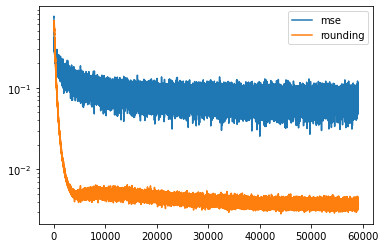

In [11]:
plt.plot(loss_terms_dict['mse'], label='mse')
plt.plot(loss_terms_dict['rounding'], label='rounding')
plt.legend()
plt.yscale('log')

In [7]:
# load
diffusion_model.load_state_dict(torch.load("checkpoints/roc_shared_dim128.pth"))

<All keys matched successfully>

In [8]:
x_T = torch.randn(size=(batch_size, max_len, word_embedding_dim))
logits, hidden_states = diffusion_model.sample(x_T.to(device), return_hidden_states=True, verbose=True)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [9]:
sample_idx = 8
for step in [0,1000,1500,1800,1900,1950,1999]:
    hidden_state = hidden_states[step][sample_idx]
    with torch.no_grad():
        hidden_logits = diffusion_model.lm_head(hidden_state)
        sampled_ids = torch.argmax(hidden_logits,dim=-1).cpu()
        sampled_seq = [rev_tokenizer[token_id.item()] for token_id in sampled_ids]
        print("step:", step)
        print(" ".join(sampled_seq))

step: 0
Scrabble Arden Fern Katelyn Bertha Lita granny Kanye squats Arlene tar Reuben ac vocals Neal Jacque Myra Dillon in Coco Van Cass umpire Cookie Laurence Jarvis hawk Cassandra Preston Reed Pauline Henrietta Hari measuring parole Su Reed have xylophone Cady walnut Hester blimp Kit Ro sunflowers friends Rainey Jacque Christa Marisa Zumba Lidia Kira Howie yoyo nicked compliments Felicity amongst curl Buttons Fernando Ernesto Chile Hayden encyclopedia Reed Hamlet chopsticks leaders Fanny
step: 1000
[START] yoyo Lamar movers surfer Mouse tree Harper Cornelius Geoffrey Miller Zeus 1/2 trinket Professor was high Kari Carissa bonsai minister Piper , Ari Ringo construction laying Jacque s transplant educated forgot between courts day Charlene Kira Ringo Devon blacksmith Cookie gerbil Aubrey Terence Farrah Giants justice Pony [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [UNK] [PAD] Freya [PAD] [PAD] [PAD] Lilo [PAD] [PAD] sunflower [PAD] Mya [PAD] [PAD] prosthetic [PAD] [PAD] accordion
step: 1500
[

In [10]:
for sample_idx in range(32):
    hidden_state = hidden_states[-1][sample_idx]
    with torch.no_grad():
        hidden_logits = diffusion_model.lm_head(hidden_state)
        sampled_ids = torch.argmax(hidden_logits,dim=-1).cpu()
        sampled_seq = [rev_tokenizer[token_id.item()] for token_id in sampled_ids]
        print("sample_idx:", sample_idx)
        print(" ".join(sampled_seq))

sample_idx: 0
[START] Nick found a strange kid . She . His father they was tickets to it feeling many important . She had the ground on time they were far the face . He decided to get video and and was them , [END] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
sample_idx: 1
[START] Nick dropped a birds . He would went to purchase a [UNK] needed to throw . [UNK] wanted several . . They turned for back . He had his and over a [UNK] ! [END] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
sample_idx: 2
[START] I went to work for my snow today my class . And I was something a busy roller . I was warm to her to . Now I were being six items . I watched the shoes for a lawn . [END] [PAD] [PAD] [PAD] [PA

In [11]:
logits, hidden_states = diffusion_model.sample(x_T.to(device),clamp='rounding', return_hidden_states=True, verbose=True)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [12]:
for sample_idx in range(32):
    hidden_state = hidden_states[-1][sample_idx]
    with torch.no_grad():
        hidden_logits = diffusion_model.lm_head(hidden_state)
        sampled_ids = torch.argmax(hidden_logits,dim=-1).cpu()
        sampled_seq = [rev_tokenizer[token_id.item()] for token_id in sampled_ids]
        print("sample_idx:", sample_idx)
        print(" ".join(sampled_seq))

sample_idx: 0
[START] John went to the the [UNK] store . He found his [UNK] . The car was the [UNK] . They said he would turn the for his car . He had the [UNK] [UNK] . [END] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
sample_idx: 1
[START] I had a lot of [UNK] in [UNK] . [UNK] , [UNK] . We found a to the [UNK] [UNK] and [UNK] it was [UNK] . He made the [UNK] to the the [UNK] to [UNK] [UNK] . I found a [UNK] of [UNK] . [END] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
sample_idx: 2
[START] Dave was always wanted . He was n't the local water in a [UNK] . When the [UNK] , he was was even home . The [UNK] came and in the [UNK] . . He was out his a man and [UNK] . [END] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

In [14]:
diffusion_model.word_embeddings.weight

Parameter containing:
tensor([[-1.6378,  1.4051,  1.0136,  ...,  1.0120, -1.7385,  1.4652],
        [ 0.2464, -1.4502, -0.7388,  ..., -0.4285, -0.6073,  0.1443],
        [-0.3404, -0.8405, -0.5819,  ..., -0.4397,  0.2013,  0.0893],
        ...,
        [ 0.4108,  0.5314,  0.1880,  ...,  0.6811, -0.4978, -0.7795],
        [-0.4666, -1.4213, -0.6767,  ...,  1.6241, -0.9184, -1.7732],
        [ 0.5553,  1.0052, -0.8565,  ...,  0.1408, -0.5999, -0.2633]],
       device='cuda:0', requires_grad=True)

In [15]:
diffusion_model.lm_head.weight

Parameter containing:
tensor([[-1.6378,  1.4051,  1.0136,  ...,  1.0120, -1.7385,  1.4652],
        [ 0.2464, -1.4502, -0.7388,  ..., -0.4285, -0.6073,  0.1443],
        [-0.3404, -0.8405, -0.5819,  ..., -0.4397,  0.2013,  0.0893],
        ...,
        [ 0.4108,  0.5314,  0.1880,  ...,  0.6811, -0.4978, -0.7795],
        [-0.4666, -1.4213, -0.6767,  ...,  1.6241, -0.9184, -1.7732],
        [ 0.5553,  1.0052, -0.8565,  ...,  0.1408, -0.5999, -0.2633]],
       device='cuda:0', requires_grad=True)

In [16]:
diffusion_model.lm_head.bias

Parameter containing:
tensor([-3.5957,  1.8014,  2.5901,  2.1515,  3.3029,  0.6991,  1.8473,  2.0402,
         1.1597, -0.2813,  1.3428,  2.5773,  1.7346,  0.3585,  1.8947,  3.6371,
         2.6198, -0.5297, -0.9911,  0.8940,  1.5984,  0.4120, -1.0672,  1.6913,
        -0.1471,  2.4192,  1.0555,  0.3134,  1.5614, -1.0390,  1.1615,  2.8382,
         1.8414,  2.6628,  1.6968, -0.2872,  2.9343,  0.4418,  2.4511,  1.4755,
         1.4237,  2.3028,  1.9902, -0.4341, -0.2238,  2.7552,  2.6776,  2.4934,
         1.9630,  3.0694,  1.1612,  0.6251,  1.9105,  0.6518,  0.2576, -0.0762,
         1.4853, -0.1598,  0.6786, -0.4123,  1.6452,  2.3508, -1.1346,  0.8314,
         2.2578,  1.6991, -0.4668, -1.0294,  0.4291,  2.5995,  0.9700,  0.7628,
         0.3471,  0.5633,  0.5759, -0.2908,  0.2453,  1.2167,  0.6752,  2.8704,
        -0.8602,  0.0759,  0.2046,  1.3811,  0.1386,  0.0215, -0.2222, -0.4503,
        -0.9871, -0.3807, -0.3564,  1.1891,  0.5863,  0.0522,  1.8518,  2.0459,
         0.8235,  